In [1]:
# installing packages
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# loading data from kaggle
from google.colab import files
files.upload() #upload kaggle.json with login and key

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"katayevanatalia","key":"fed0cc401c2c644b058d95bf2c9f51b5"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c digit-recognizer --force

 91% 14.0M/15.3M [00:00<00:00, 22.4MB/s]
100% 15.3M/15.3M [00:00<00:00, 16.3MB/s]


In [8]:
!mkdir digit-recognizer
!unzip digit-recognizer.zip -d digit-recognizer

Archive:  digit-recognizer.zip
  inflating: digit-recognizer/sample_submission.csv  
  inflating: digit-recognizer/test.csv  
  inflating: digit-recognizer/train.csv  


In [9]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, Dense, AvgPool1D, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## Data Analysis and preprocessing

In [10]:
train = pd.read_csv("/content/digit-recognizer/train.csv")
test = pd.read_csv("/content/digit-recognizer/test.csv")

In [11]:
# function to preview the dataframe
def data_preview(data):
    name =[x for x in globals() if globals()[x] is data][0]
    print('Информация о таблице', name, ':')
    display(data.info())
    with pd.option_context('display.max_columns', None):
        display(data.head(5))  
    print(data.isna().sum().sort_values(ascending=False).head(20))
    print(data.duplicated().sum())

In [12]:
data_preview(train)

Информация о таблице train :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


None

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

label       0
pixel515    0
pixel517    0
pixel518    0
pixel519    0
pixel520    0
pixel521    0
pixel522    0
pixel523    0
pixel524    0
pixel525    0
pixel526    0
pixel527    0
pixel528    0
pixel529    0
pixel530    0
pixel531    0
pixel532    0
pixel533    0
pixel534    0
dtype: int64
0


In [13]:
data_preview(test)

Информация о таблице test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


None

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455,pixel

pixel0      0
pixel515    0
pixel517    0
pixel518    0
pixel519    0
pixel520    0
pixel521    0
pixel522    0
pixel523    0
pixel524    0
pixel525    0
pixel526    0
pixel527    0
pixel528    0
pixel529    0
pixel530    0
pixel531    0
pixel532    0
pixel533    0
pixel534    0
dtype: int64
0


<Axes: >

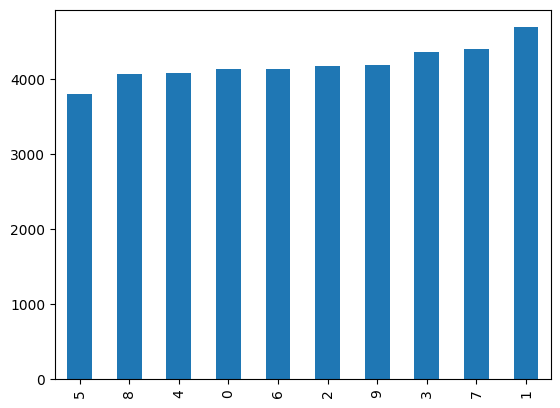

In [14]:
# plotting the distribution of labels
train['label'].value_counts().sort_values().plot(kind='bar')

In [15]:
# displaying shares of different labels
for i in range(0,10):
    label_percentage = len(train[train['label'] == i]) / len(train['label']) 
    print(f'A share of {i} label is {label_percentage:.1%}')

A share of 0 label is 9.8%
A share of 1 label is 11.2%
A share of 2 label is 9.9%
A share of 3 label is 10.4%
A share of 4 label is 9.7%
A share of 5 label is 9.0%
A share of 6 label is 9.8%
A share of 7 label is 10.5%
A share of 8 label is 9.7%
A share of 9 label is 10.0%


The dataset includes 42000 entries. Each entry contains a series of numbers in range [0,255] for each pixel of a picture, and a label containing a number 0-9 written in the picture. 
the proportion of each label value is approximately 10% of the total dataset.
There are no missing values or duplicates in the dataset. 

In [16]:
# defining features and a target
y_train_all = train["label"].values
x_train_all = train.drop("label", axis=1)
x_train_visualize = x_train_all.values.reshape(-1, 28, 28)

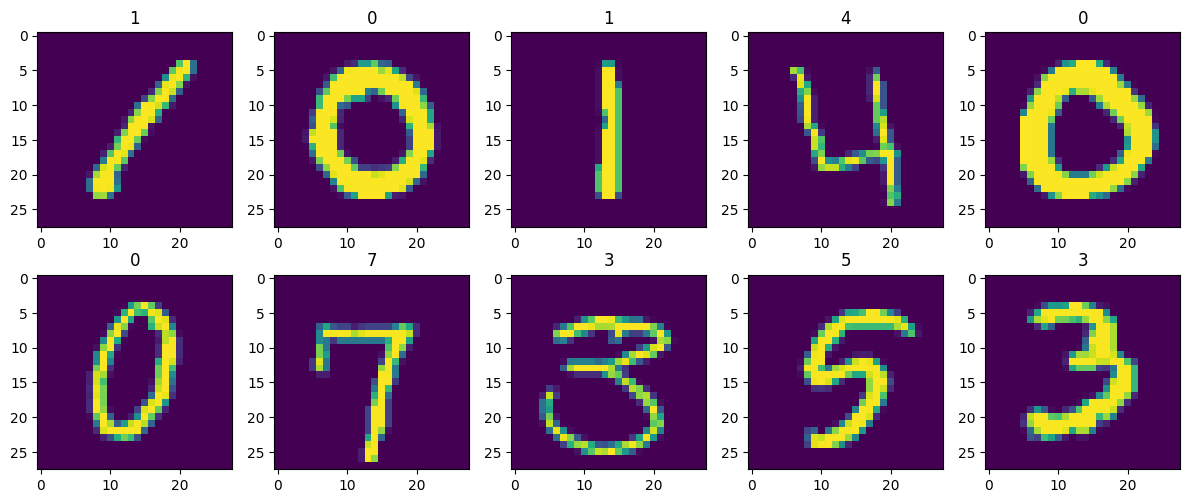

In [18]:
# plotting a sample of numbers and labels
plt.figure(figsize=(12, 5), tight_layout=True)

for idx, digit in enumerate(x_train_visualize[:10]):
    plt.subplot(2, 5, idx + 1)
    plt.title(y_train_all[idx])
    plt.imshow(digit)

plt.show()

In [19]:
# normalization
x_train_all = x_train_all / 255.0

In [20]:
# splitting the dataset
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=12345, stratify=y_train_all) # разделили выборки в пропорции 2 к 8

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(33600, 784)
(33600,)
(8400, 784)
(8400,)


## Building neural networks

### Fully connected NN

In [26]:
y_train_fcnn = to_categorical(y_train, 28)
y_valid_fcnn = to_categorical(y_valid, 28)

In [35]:
model_fcnn = keras.models.Sequential()

# adding dense layers
model_fcnn.add(keras.layers.Dense(units=100, 
                             activation='sigmoid'))
model_fcnn.add(keras.layers.Dense(units=28, 
                             activation='relu'))
model_fcnn.add(keras.layers.Dense(units=28, 
                             activation='softmax'))
model_fcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history_fcnn = model_fcnn.fit(x_train, y_train_fcnn, epochs=10, verbose=2, validation_data=(x_valid, y_valid_fcnn))
model_fcnn.summary()

Epoch 1/10
1050/1050 - 5s - loss: 0.5947 - acc: 0.8390 - val_loss: 0.2768 - val_acc: 0.9193 - 5s/epoch - 5ms/step
Epoch 2/10
1050/1050 - 3s - loss: 0.2235 - acc: 0.9343 - val_loss: 0.2095 - val_acc: 0.9373 - 3s/epoch - 3ms/step
Epoch 3/10
1050/1050 - 3s - loss: 0.1668 - acc: 0.9504 - val_loss: 0.1747 - val_acc: 0.9460 - 3s/epoch - 3ms/step
Epoch 4/10
1050/1050 - 4s - loss: 0.1306 - acc: 0.9604 - val_loss: 0.1536 - val_acc: 0.9520 - 4s/epoch - 4ms/step
Epoch 5/10
1050/1050 - 3s - loss: 0.1062 - acc: 0.9682 - val_loss: 0.1338 - val_acc: 0.9583 - 3s/epoch - 3ms/step
Epoch 6/10
1050/1050 - 4s - loss: 0.0864 - acc: 0.9745 - val_loss: 0.1269 - val_acc: 0.9604 - 4s/epoch - 3ms/step
Epoch 7/10
1050/1050 - 4s - loss: 0.0726 - acc: 0.9785 - val_loss: 0.1194 - val_acc: 0.9619 - 4s/epoch - 4ms/step
Epoch 8/10
1050/1050 - 3s - loss: 0.0588 - acc: 0.9829 - val_loss: 0.1182 - val_acc: 0.9626 - 3s/epoch - 3ms/step
Epoch 9/10
1050/1050 - 4s - loss: 0.0491 - acc: 0.9855 - val_loss: 0.1149 - val_acc: 0.9

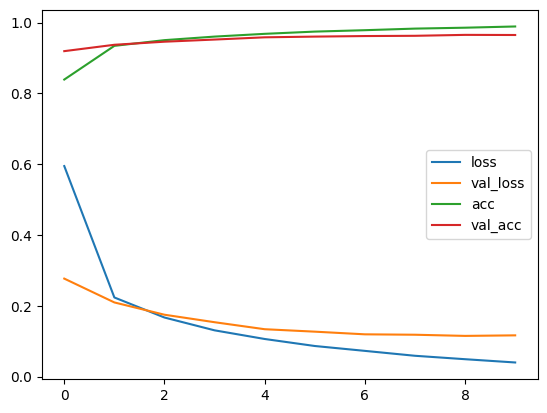

In [44]:
plt.plot(history_fcnn.history['loss'], label="loss")
plt.plot(history_fcnn.history['val_loss'], label="val_loss")
plt.plot(history_fcnn.history['acc'], label="acc")
plt.plot(history_fcnn.history['val_acc'], label="val_acc")
plt.legend(loc="center right")

### Convolutional NN: LeNet

In [24]:
x_train_conv = x_train.values.reshape(-1, 28, 28)
x_valid_conv = x_valid.values.reshape(-1, 28, 28)

In [34]:
model_conv = Sequential()

model_conv.add(Conv2D(6, (3, 3), padding='same', activation='tanh',
                 input_shape=(28, 28, 1)))
model_conv.add(AvgPool2D(pool_size=(2, 2)))
model_conv.add(Conv2D(16, (3, 3), padding='valid', activation='tanh',
                 input_shape=(10, 10, 1)))
model_conv.add(AvgPool2D(pool_size=(2, 2)))
model_conv.add(Flatten())
model_conv.add(Dense(units=120, activation='tanh'))
model_conv.add(Dense(units=84, activation='tanh'))
model_conv.add(Dense(units=10, activation='softmax'))

model_conv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_conv.summary()
history_conv = model_conv.fit(x_train_conv, y_train, epochs=4, verbose=1,
          steps_per_epoch=x_train_conv.shape[0]//84, validation_data=(x_valid_conv, y_valid), validation_steps=x_valid_conv.shape[0]//84)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         60        
                                                                 
 average_pooling2d_6 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 16)        880       
                                                                 
 average_pooling2d_7 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 576)               0         
                                                                 
 dense_15 (Dense)            (None, 120)              

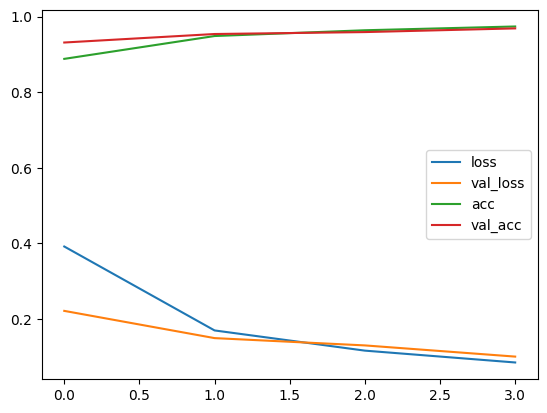

In [45]:
plt.plot(history_conv.history['loss'], label="loss")
plt.plot(history_conv.history['val_loss'], label="val_loss")
plt.plot(history_conv.history['acc'], label="acc")
plt.plot(history_conv.history['val_acc'], label="val_acc")
plt.legend(loc="center right")

In [30]:
# saving the best model
model_conv.save('model_conv.h5')

### Making predictions

In [32]:
test_conv = test.values.reshape(-1, 28, 28) / 255

In [33]:
# making predictions
results = model_conv.predict(test_conv, verbose=0).argmax(axis=1)

# saving predictions to csv
sumbission = pd.DataFrame({"ImageID": range(1, len(test_conv) + 1), "Label": results})
sumbission.set_index("ImageID").to_csv("submission.csv")

sumbission.head()

,ImageID,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
